The purpose of this document is to supplement the fill layers with lithology from CGS in order to better constrain the fill depth at locations across Alameda. 

This will supplement the layer models from CPT change point detection and will better constrain the top layer of soil. This is more automatable/repeatable than digitizing from boreholes, but the variation depending on the amount and types of data can be compared as well. 


The inputs are saved in clean_examples.ipynb

parameters are a = 1, b = 20, t_ref = 5

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import utm
import matplotlib.pyplot as plt
from scipy import stats
from pykrige.ok import OrdinaryKriging
from shapely.geometry import LineString, Point
import contextily as ctx
from collections import Counter
from shapely.affinity import translate

from regional_K.cpt_functions import setup_cpt, calc_SBT, soil_stress, solve_Ic, k_from_Ic, setup_grid

import warnings
warnings.filterwarnings("ignore")

In [ ]:
cpt = setup_cpt('./USGS_CPT_data/')
layers = pd.read_csv('./layer_thicknesses.csv', index_col=0)
# MS_layers = pd.read_csv('sand_cp_layers.csv', index_col=0)
MS_layers = pd.read_csv('new_sand_cp_layers.csv', index_col=0)
MSAF_layers = pd.read_csv('new_msaf_cp_layers.csv', index_col=0)

cpt = soil_stress(cpt)
calc_SBT(cpt)
for _, data in cpt.items():
    data['CPT_data']['I_c'] = solve_Ic(data['CPT_data']['q_c'], data['CPT_data']['sig_v'],data['CPT_data']['sig_prime_v'], data['CPT_data']['f_s'])
    data['CPT_data']['k_fromIc'] = k_from_Ic(data['CPT_data']['I_c'])

In [ ]:
points = setup_grid(geoplot='./geojson/alameda_city.geojson')
points['utmX'] = pd.to_numeric(points['utmX'], errors='coerce')
points['utmY'] = pd.to_numeric(points['utmY'], errors='coerce')

# Drop any rows in points with non-numeric values
points = points.dropna(subset=['utmX', 'utmY'])

In [ ]:
shapefile_path = './deposits_shp/sfq2py.shp'
data = gpd.read_file(shapefile_path)
data.crs = 'EPSG:4326'
joined = gpd.sjoin(points.drop(['index_right'], axis=1), data, how='left') #, op='within')

In [ ]:
gdf_layers = gpd.GeoDataFrame(layers, geometry=[Point(x, y) for x, y in zip(layers['UTM -X'], layers['UTM -Y'])],crs='EPSG:32610')
gdf_layers = gdf_layers.to_crs('EPSG:4326')
geo_layers = gpd.sjoin(gdf_layers,data , how='left')
## make geo_layers['Fill'] 0 where PTYPE is NOT H2O or afem
geo_layers.loc[~geo_layers['PTYPE'].isin(['H2O','afem']),'Fill'] = 0  ## this alters the heuristic data

# Define the bounds of the grid
minx, miny, maxx, maxy = geo_layers.total_bounds

# Create a grid of points within these bounds
spacing = 0.008  # Define spacing between grid points (adjust as needed)
x_coords = np.arange(minx, maxx, spacing)
y_coords = np.arange(miny, maxy, spacing)
grid_points = [Point(x, y) for x in x_coords for y in y_coords]

# Convert grid points to a GeoDataFrame
grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=geo_layers.crs)

# Filter out grid points that overlap with 'H2O' or 'afem' regions in data
filtered_gdf = grid_gdf[~grid_gdf.sjoin(data[data['PTYPE'].isin(['H2O', 'afem'])], how='left', predicate='intersects').index_right.notnull()]
filtered_gdf['Fill'] = 0

# Add these new points to geo_layers
geo_layers_append = pd.concat([geo_layers, filtered_gdf], ignore_index=True)

MS_layers[['lat','lon']] = MS_layers.apply(lambda x: utm.to_latlon(x['UTM -X'], x['UTM -Y'], 10, 'N'), axis=1, result_type='expand')
MS_layers = gpd.GeoDataFrame(MS_layers, geometry = gpd.points_from_xy(MS_layers['lon'], MS_layers['lat']), crs='EPSG:4326')
MSAF_layers[['lat','lon']] = MS_layers.apply(lambda x: utm.to_latlon(x['UTM -X'], x['UTM -Y'], 10, 'N'), axis=1, result_type='expand')
MSAF_layers = gpd.GeoDataFrame(MSAF_layers, geometry = gpd.points_from_xy(MSAF_layers['lon'], MSAF_layers['lat']), crs='EPSG:4326')

MS_layers_append = pd.concat([MS_layers, filtered_gdf], ignore_index=True)
MSAF_layers_append = pd.concat([MSAF_layers, filtered_gdf], ignore_index=True)



#### First run for Fill

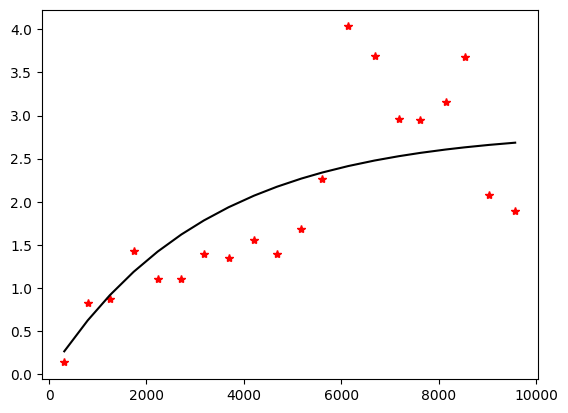

In [ ]:
# Interpolation for each depth field
depth_type = 'Fill'
# Ensure depth values are numeric
geo_layers_append[depth_type] = pd.to_numeric(geo_layers_append[depth_type], errors='coerce')

# fill in utm from geometry in 4326
geo_layers_append[['UTM -X', 'UTM -Y']] = geo_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)

# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = geo_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 20, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['Heuristic Fill'] = z_interp



In [ ]:
## match UTM -X and UTM -Y to the MS and MSAF layers based on the index/Filename
MS_layers=MS_layers.merge(layers[['UTM -X', 'UTM -Y']], left_on=MS_layers.index, right_on=layers['Filename'])
MSAF_layers=MSAF_layers.merge(layers[['UTM -X', 'UTM -Y']], left_on=MSAF_layers.index, right_on=layers['Filename'])


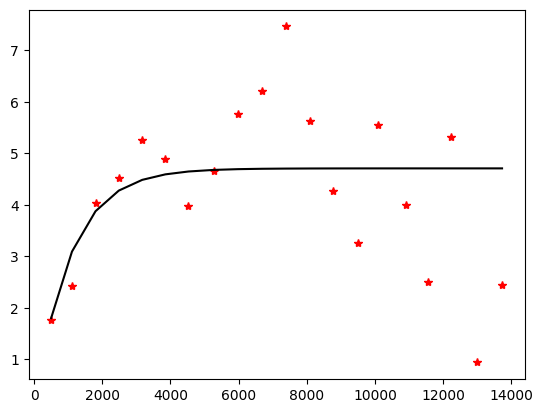

In [ ]:
# Interpolation for each depth field
depth_type = 'Fill'
# Ensure depth values are numeric
MS_layers_append[depth_type] = pd.to_numeric(MS_layers_append[depth_type], errors='coerce')

MS_layers_append[['UTM -X', 'UTM -Y']] = MS_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)
# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = MS_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 20, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['MS Method Fill'] = z_interp

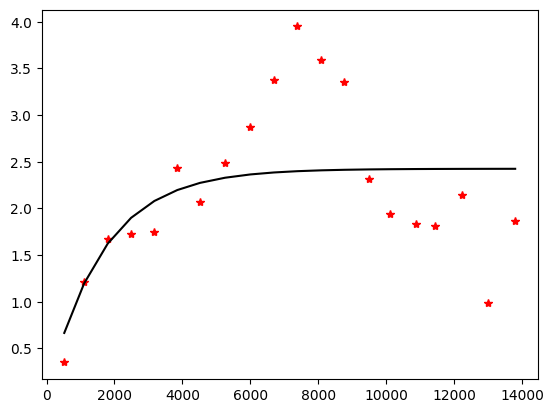

In [ ]:
# Interpolation for each depth field
depth_type = 'Fill'
# Ensure depth values are numeric
MSAF_layers_append[depth_type] = pd.to_numeric(MSAF_layers_append[depth_type], errors='coerce')
MSAF_layers_append[['UTM -X', 'UTM -Y']] = MSAF_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)
# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = MSAF_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 20, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['MSAF Method Fill'] = z_interp

Text(0.5, 1.0, 'Heuristic')

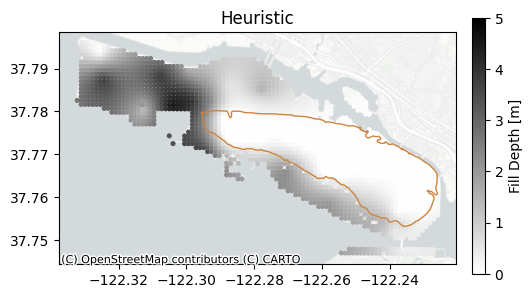

In [ ]:
point_of_interest = Point(-122.26, 37.77)
intersecting_row = data[data['geometry'].intersects(point_of_interest)]
x_offset = -0.001  # Adjust this value to shift more or less to the left
y_offset = 0       # No vertical shift
intersecting_row['geometry'] = intersecting_row['geometry'].apply(lambda geom: translate(geom, xoff=x_offset, yoff=y_offset))

ax=points.plot(column='Heuristic Fill', legend=True,markersize=7,vmin = 0, vmax=5, cmap='gist_gray_r')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Fill Depth [m]')
# make the cbar smaller 90% of the original size
cbar.set_position([0.77, 0.22, 0.02, 0.56])

# plot the outline of intersecting_row
intersecting_row.plot(ax=ax, edgecolor='peru',color='none',linewidth=1)


# plt.savefig('./figures/fill_map_heur.png', format='png', dpi=1000)
# plt.savefig('./figures/fill_map_heur.pdf', format='pdf', dpi=1000)

plt.title('Heuristic')

Text(0.5, 1.0, 'CP, MS')

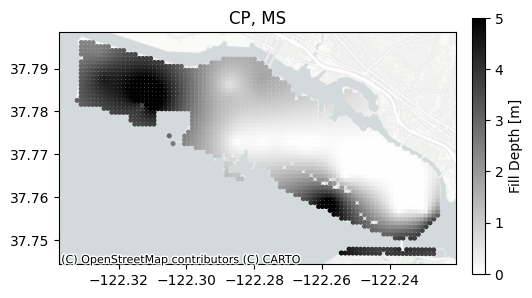

In [ ]:
ax=points.plot(column='MS Method Fill', legend=True,markersize=7,vmin = 0, vmax=5, cmap='gist_gray_r')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Fill Depth [m]')
cbar.set_position([0.77, 0.22, 0.02, 0.56])

plt.savefig('./figures/fill_map_CPMS.png', format='png', dpi=1000)
plt.savefig('./figures/fill_map_CPMS.pdf', format='pdf', dpi=1000)

plt.title('CP, MS')

Text(0.5, 1.0, 'CP, MSAF')

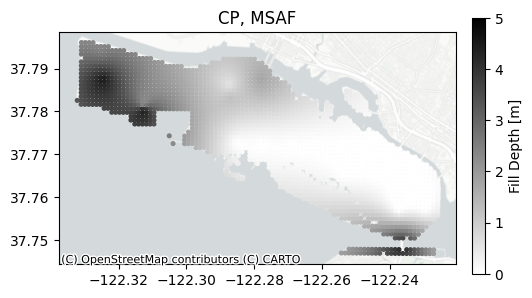

In [ ]:
ax=points.plot(column='MSAF Method Fill', legend=True,markersize=7,vmin = 0, vmax=5, cmap='gist_gray_r')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Fill Depth [m]')
cbar.set_position([0.77, 0.22, 0.02, 0.56])

plt.savefig('./figures/fill_map_CPMSAF.png', format='png', dpi=1000)
plt.savefig('./figures/fill_map_CPMSAF.pdf', format='pdf', dpi=1000)
plt.title('CP, MSAF')

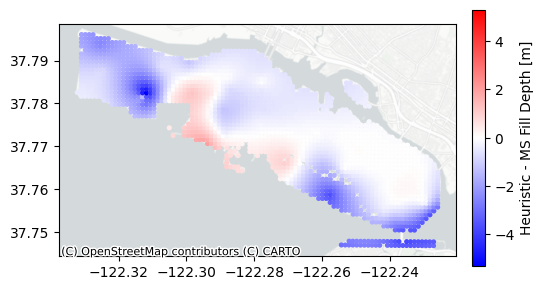

In [ ]:
points['heur-MS'] = points['Heuristic Fill'] - points['MS Method Fill']
points['heur-MSAF'] = points['Heuristic Fill'] - points['MSAF Method Fill']
points['MS-MSAF'] = points['MS Method Fill'] - points['MSAF Method Fill']

lim = max(abs(points['heur-MS']).max(),abs(points['heur-MSAF']).max(),abs(points['MS-MSAF']).max())

ax=points.plot(column='heur-MS', legend=True,markersize=7, cmap='bwr',vmin=-lim,vmax=lim)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Heuristic - MS Fill Depth [m]')
cbar.set_position([0.77, 0.22, 0.02, 0.56])

plt.savefig('./figures/fill_map_CPMS_diff.png', format='png', dpi=1000)
plt.savefig('./figures/fill_map_CPMS_diff.pdf', format='pdf', dpi=1000)


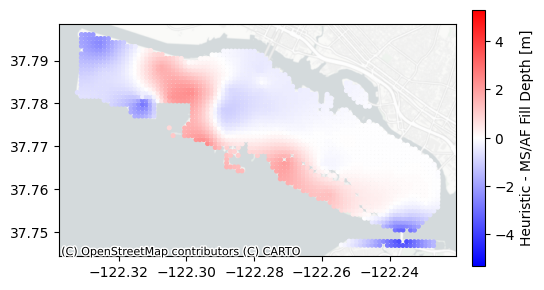

In [ ]:
ax=points.plot(column='heur-MSAF', legend=True,markersize=7, cmap='bwr',vmin=-lim,vmax=lim)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Heuristic - MS/AF Fill Depth [m]')
cbar.set_position([0.77, 0.22, 0.02, 0.56])

plt.savefig('./figures/fill_map_CPMSAF_diff.png', format='png', dpi=1000)
plt.savefig('./figures/fill_map_CPMSAF_diff.pdf', format='pdf', dpi=1000)

Text(555.7327777777779, 0.5, 'MS - MS/AF Fill Depth [m]')

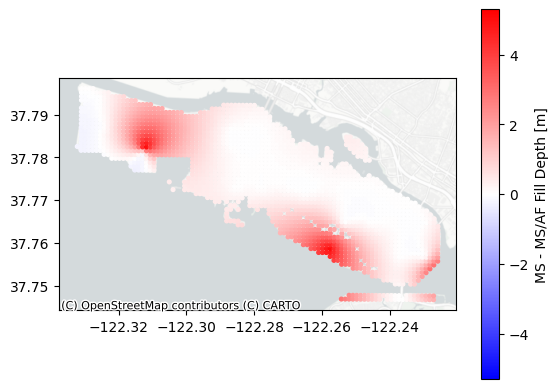

In [ ]:
ax=points.plot(column='MS-MSAF', legend=True,markersize=7, cmap='bwr',vmin=-lim,vmax=lim)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('MS - MS/AF Fill Depth [m]')

In [ ]:
cgs_data = pd.read_csv('./cgs_bhs_0/CGSBoreholeDB_BoreholeLocations.csv')

## load in additional lithology data and extract fill depths
lith = pd.read_csv('./cgs_bhs_0/lithology.csv')
lith = lith[lith['remarks'].str.contains('fill', case=False, na=False)]


## match lith to cgs_data baesd on well_name to get latitude and longitude
lith = lith.merge(cgs_data[['well_name', 'latitude', 'longitude']], on='well_name', how='left')

lith_gdf = gpd.GeoDataFrame(lith, geometry=gpd.points_from_xy(lith.longitude, lith.latitude),crs='EPSG:4326')
lith_gdf['Fill'] = lith_gdf['bottom_depth'] * 0.3048 # convert to meters



In [ ]:
cpt_gdf = gpd.GeoDataFrame({'cpt_name': list(cpt.keys()), 'geometry': [Point(cpt[well]['Lon'], cpt[well]['Lat']) for well in cpt.keys()]}, crs='EPSG:4326')


In [ ]:
layers_gdf = gpd.GeoDataFrame(layers, geometry = gpd.points_from_xy(layers['UTM -X'], layers['UTM -Y']), crs='EPSG:32610')
layers_gdf.to_crs('EPSG:4326', inplace=True)


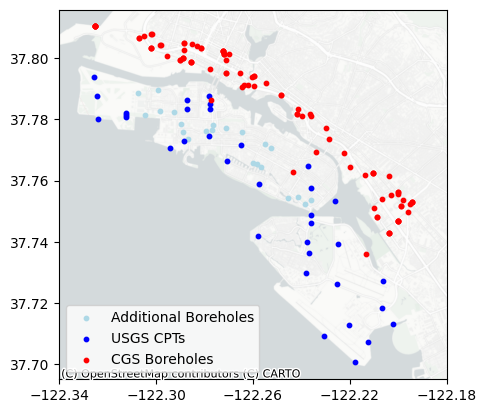

In [ ]:
## plot a map with the lith locations in one color and cpt locations in another
ax = layers_gdf.plot(color='lightblue', markersize=10)
cpt_gdf.plot(ax=ax,color='blue', markersize=10)
lith_gdf.plot(ax=ax, color='red', markersize=10)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs ='EPSG:4326')
plt.legend(['Additional Boreholes','USGS CPTs', 'CGS Boreholes'])
# make half as many ticks
xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])


In [ ]:
## drop the 64 from the lith data index, it said 'filled' and was not artificial fill.
# lith = lith[lith.index != 64]
# lith_gdf = lith_gdf[lith_gdf.index != 64]

In [ ]:
# get the Fill column from layers into cpt_gdf based on Filename/Well Name
# cpt_gdf.drop(columns=['Fill', 'Filename','key_0'], inplace=True)
cpt_gdf = cpt_gdf.merge(layers[['Fill', 'Filename']], left_on=cpt_gdf['cpt_name'].astype(str), right_on=layers['Filename'].astype(str), how='left')


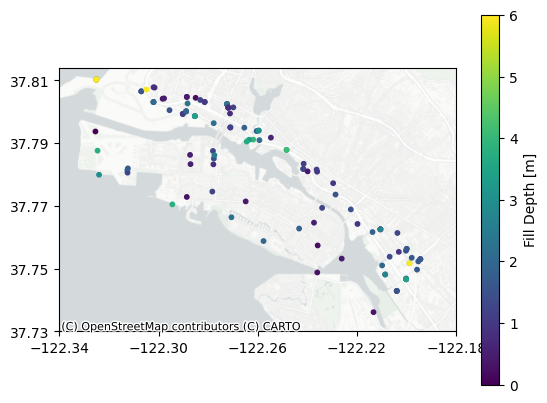

In [ ]:
vmin = min(cpt_gdf['Fill'].min(), lith_gdf['Fill'].min())
vmax = min(max(cpt_gdf['Fill'].max(), lith_gdf['Fill'].max()),6)

ax = cpt_gdf.plot(column='Fill', cmap='viridis', legend=False, vmin=vmin, vmax=vmax, markersize=10)
lith_gdf.plot(ax=ax, column='Fill', cmap='viridis', legend=False, vmin=vmin, vmax=vmax, markersize=10)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs='EPSG:4326')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Required for ScalarMappable
cbar = plt.colorbar(sm, ax=ax, label='Fill Depth [m]')
xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])
yticks = ax.get_yticks()
ax.set_yticks(yticks[::2])
plt.show()


In [ ]:
filtered_gdf[['UTM -X', 'UTM -Y']] = filtered_gdf.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)

In [ ]:
# combine layers and lith 
lith_gdf['UTM -X'], lith_gdf['UTM -Y'] = zip(*[utm.from_latlon(lat, lon)[:2] for lat, lon in zip(lith_gdf['latitude'], lith_gdf['longitude'])])

layers_gdf_append = pd.concat([layers_gdf, filtered_gdf], ignore_index=True)
supp_heuristic = pd.concat([layers_gdf_append[['UTM -X', 'UTM -Y', 'Fill']], lith_gdf[['UTM -X', 'UTM -Y', 'Fill']]], axis=0)

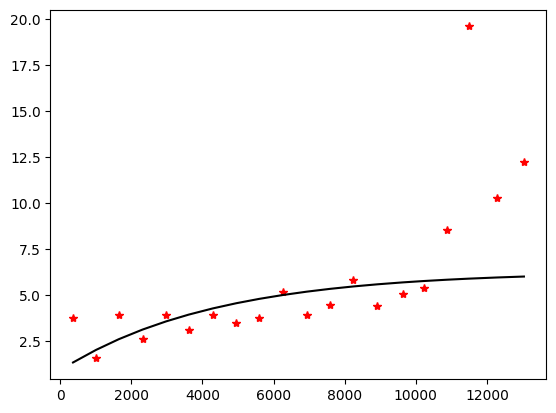

In [ ]:
# Interpolation for each depth field
depth_type = 'Fill'
# Ensure depth values are numeric
supp_heuristic[depth_type] = pd.to_numeric(supp_heuristic[depth_type], errors='coerce')

# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = supp_heuristic.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 20, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['Supplemented Heuristic Fill'] = z_interp

Text(557.3577777777779, 0.5, 'Fill Depth [m]')

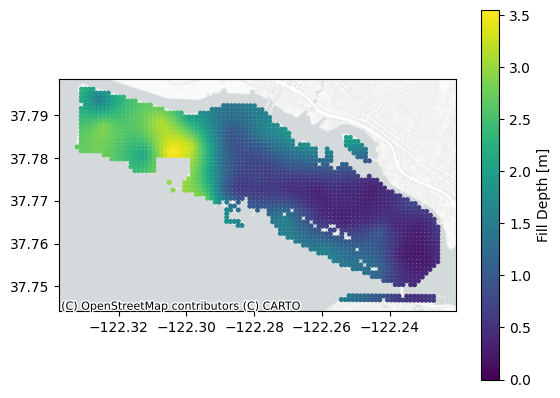

In [ ]:
ax=points.plot(column='Supplemented Heuristic Fill', legend=True,markersize=7,vmin = 0)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Fill Depth [m]')

Text(555.7327777777779, 0.5, 'Heuristic - Supplemented Heuristic Fill Depth [m]')

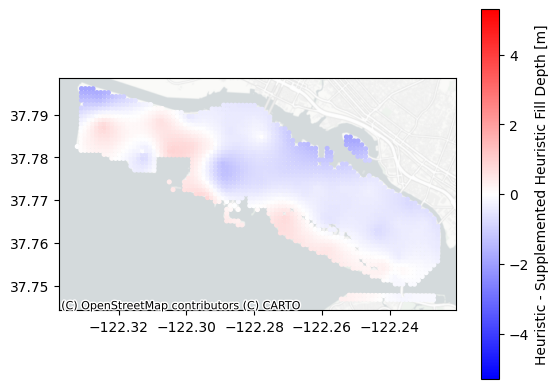

In [ ]:
points['heur-cgs'] = points['Heuristic Fill'] - points['Supplemented Heuristic Fill']
lim = max(abs(points['heur-MS']).max(),abs(points['heur-MSAF']).max(),abs(points['MS-MSAF']).max())

ax=points.plot(column='heur-cgs', legend=True,markersize=7, cmap='bwr',vmin=-lim,vmax=lim)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Heuristic - Supplemented Heuristic Fill Depth [m]')

#### Next I should run the same with the Hudson 2023 data

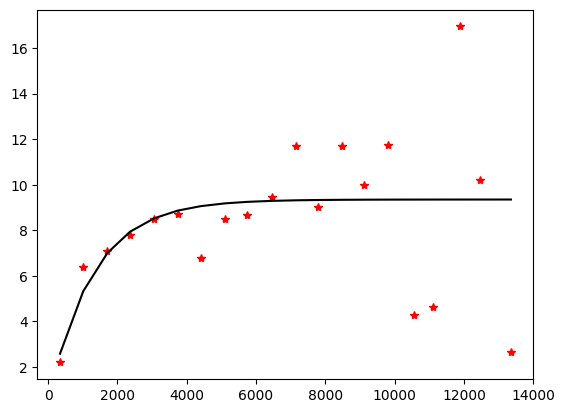

In [ ]:
hudson_ms_layers = pd.read_csv('hudson_ms_layers.csv',index_col=0)
hudson_msaf_layers = pd.read_csv('hudson_msaf_layers.csv',index_col=0)
hudson_ms_layers[['lat','lon']] = hudson_ms_layers.apply(lambda x: utm.to_latlon(x['UTM -X'], x['UTM -Y'], 10, 'N'), axis=1, result_type='expand')
hudson_ms_layers = gpd.GeoDataFrame(hudson_ms_layers, geometry = gpd.points_from_xy(hudson_ms_layers['lon'], hudson_ms_layers['lat']), crs='EPSG:4326')
hudson_msaf_layers[['lat','lon']] = hudson_msaf_layers.apply(lambda x: utm.to_latlon(x['UTM -X'], x['UTM -Y'], 10, 'N'), axis=1, result_type='expand')
hudson_msaf_layers = gpd.GeoDataFrame(hudson_msaf_layers, geometry = gpd.points_from_xy(hudson_msaf_layers['lon'], hudson_msaf_layers['lat']), crs='EPSG:4326')

hudson_ms_layers_append = pd.concat([hudson_ms_layers, filtered_gdf], ignore_index=True)
hudson_msaf_layers_append = pd.concat([hudson_msaf_layers, filtered_gdf], ignore_index=True)

# Interpolation for each depth field
depth_type = 'Fill'
# Ensure depth values are numeric
hudson_ms_layers_append[depth_type] = pd.to_numeric(hudson_ms_layers_append[depth_type], errors='coerce')

hudson_ms_layers_append[['UTM -X', 'UTM -Y']] = hudson_ms_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)
# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = hudson_ms_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 20, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['MS Hudson Fill'] = z_interp

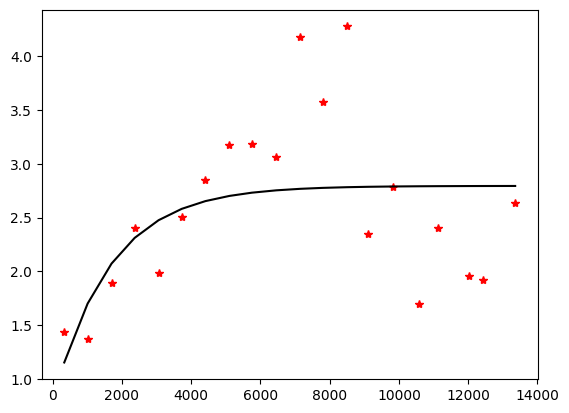

In [ ]:
# Interpolation for each depth field
depth_type = 'Fill'
# Ensure depth values are numeric
hudson_msaf_layers_append[depth_type] = pd.to_numeric(hudson_msaf_layers_append[depth_type], errors='coerce')

hudson_msaf_layers_append[['UTM -X', 'UTM -Y']] = hudson_msaf_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)
# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = hudson_msaf_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 20, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['MSAF Hudson Fill'] = z_interp

Text(0.5, 1.0, 'Hudson 2023, MS')

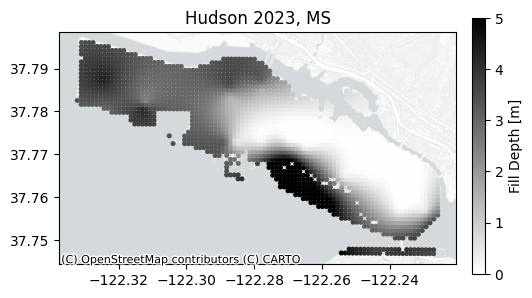

In [ ]:
ax=points.plot(column='MS Hudson Fill', legend=True,markersize=7,vmin = 0, vmax=5, cmap='gist_gray_r')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Fill Depth [m]')
cbar.set_position([0.77, 0.22, 0.02, 0.56])

plt.savefig('./figures/fill_map_hudMS.png', format='png', dpi=1000)
plt.savefig('./figures/fill_map_hudMS.pdf', format='pdf', dpi=1000)
plt.title('Hudson 2023, MS')

Text(0.5, 1.0, 'Hudson 2023, MSAF')

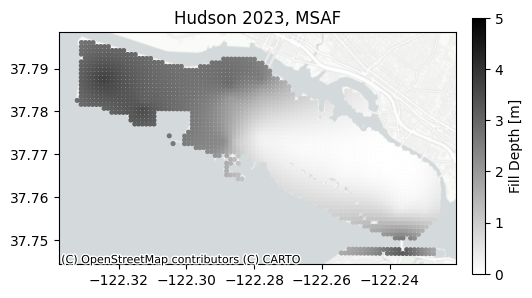

In [ ]:
ax=points.plot(column='MSAF Hudson Fill', legend=True,markersize=7,vmin = 0, vmax=5, cmap='gist_gray_r')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Fill Depth [m]')
cbar.set_position([0.77, 0.22, 0.02, 0.56])

plt.savefig('./figures/fill_map_hudMSAF.png', format='png', dpi=1000)
plt.savefig('./figures/fill_map_hudMSAF.pdf', format='pdf', dpi=1000)
plt.title('Hudson 2023, MSAF')

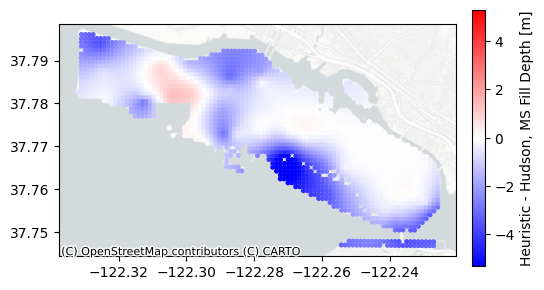

In [ ]:
points['heur-MSHud'] = points['Heuristic Fill'] - points['MS Hudson Fill']
points['heur-MSAFHud'] = points['Heuristic Fill'] - points['MSAF Hudson Fill']

# lim = max(abs(points['heur-MS']).max(),abs(points['heur-MSAF']).max(),abs(points['MS-MSAF']).max())

ax=points.plot(column='heur-MSHud', legend=True,markersize=7, cmap='bwr',vmin=-lim,vmax=lim)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Heuristic - Hudson, MS Fill Depth [m]')
cbar.set_position([0.77, 0.22, 0.02, 0.56])

plt.savefig('./figures/fill_map_hudMS_diff.png', format='png', dpi=1000)
plt.savefig('./figures/fill_map_hudMS_diff.pdf', format='pdf', dpi=1000)


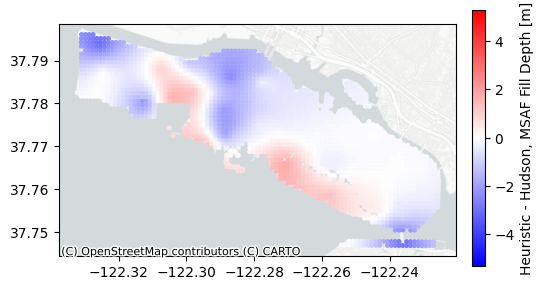

In [ ]:
ax=points.plot(column='heur-MSAFHud', legend=True,markersize=7, cmap='bwr',vmin=-lim,vmax=lim)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Heuristic - Hudson, MSAF Fill Depth [m]')
cbar.set_position([0.77, 0.22, 0.02, 0.56])

plt.savefig('./figures/fill_map_hudMSAF_diff.png', format='png', dpi=1000)
plt.savefig('./figures/fill_map_hudMSAF_diff.pdf', format='pdf', dpi=1000)

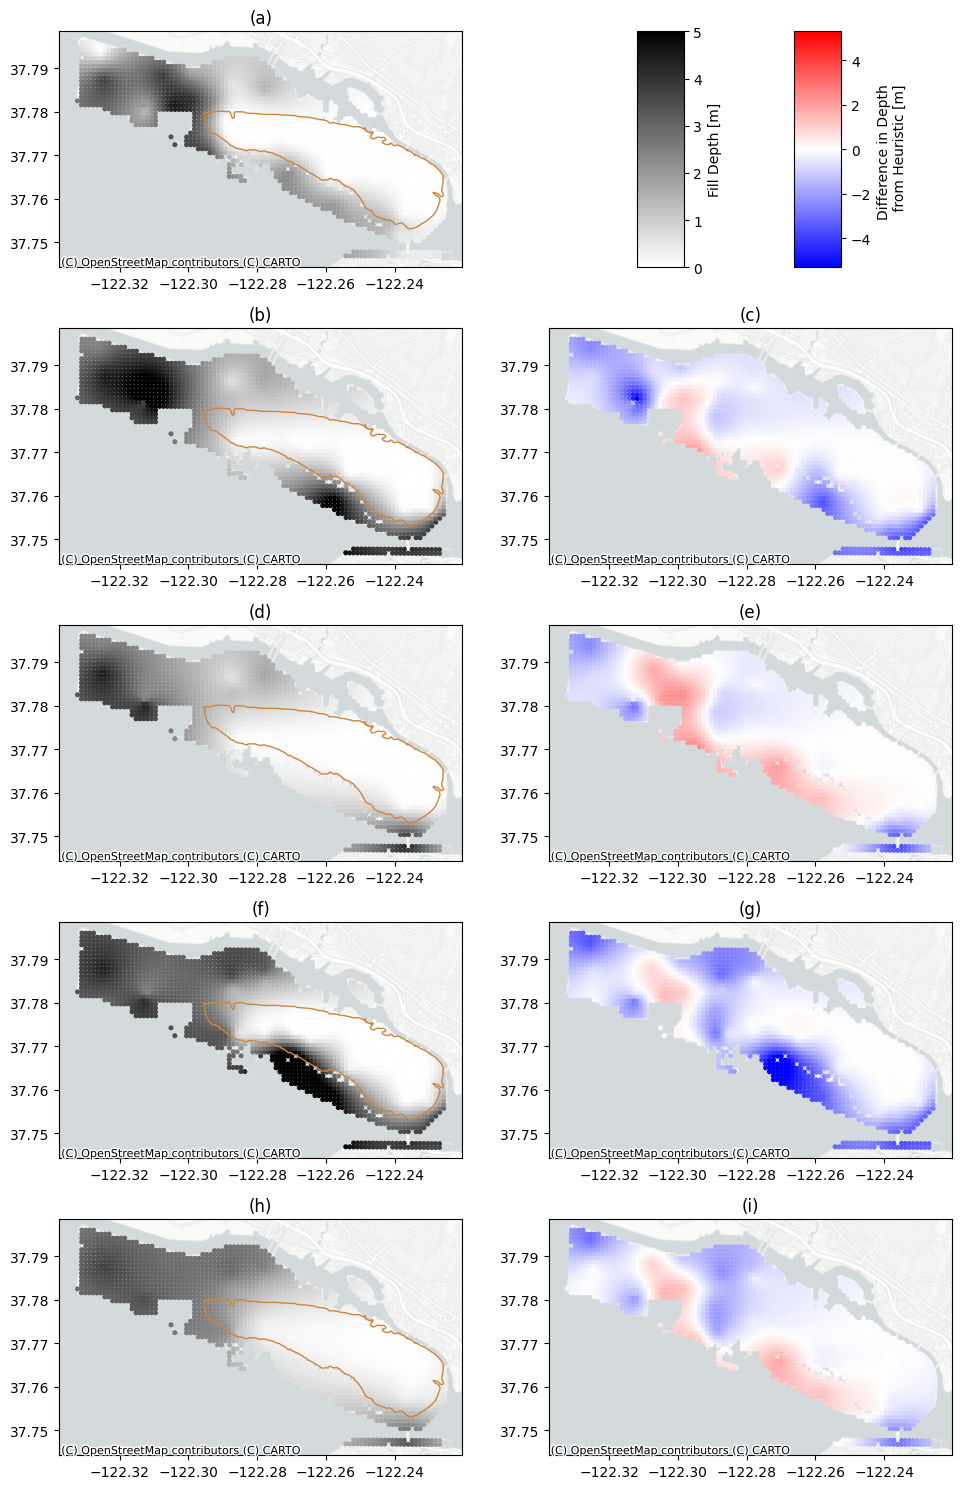

In [ ]:
# I want the above figures laid out like this:
# Heuristic top center
# next row with CPMS left and heur-CPMS right
# then down the rows will be CP MSAF , hud MS, hud MSAF with the differences to the right
# and label them (a) (b) (c) and so on 
# the subplots should have one center top then four rows (5 total) of two columns
fig, axs = plt.subplots(5, 2, figsize=(10, 15))
ax = points.plot(column='Heuristic Fill', legend=False,markersize=7,vmin = 0, vmax=5, cmap='gist_gray_r', ax=axs[0,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
intersecting_row.plot(ax=ax, edgecolor='peru',color='none',linewidth=1)

ax.set_title('(a)')

ax = points.plot(column='MS Method Fill', legend=False,markersize=7,vmin = 0, vmax=5, cmap='gist_gray_r', ax=axs[1,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
intersecting_row.plot(ax=ax, edgecolor='peru',color='none',linewidth=1)
ax.set_title('(b)')

ax = points.plot(column='heur-MS', legend=False,markersize=7, cmap='bwr',vmin=-lim,vmax=lim, ax=axs[1,1])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(c)')

ax = points.plot(column='MSAF Method Fill', legend=False,markersize=7,vmin = 0, vmax=5, cmap='gist_gray_r', ax=axs[2,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
intersecting_row.plot(ax=ax, edgecolor='peru',color='none',linewidth=1)
ax.set_title('(d)')

ax = points.plot(column='heur-MSAF', legend=False,markersize=7, cmap='bwr',vmin=-lim,vmax=lim, ax=axs[2,1])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(e)')

ax = points.plot(column='MS Hudson Fill', legend=False,markersize=7,vmin = 0, vmax=5, cmap='gist_gray_r', ax=axs[3,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
intersecting_row.plot(ax=ax, edgecolor='peru',color='none',linewidth=1)
ax.set_title('(f)')

ax = points.plot(column='heur-MSHud', legend=False,markersize=7, cmap='bwr',vmin=-lim,vmax=lim, ax=axs[3,1])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(g)')

ax = points.plot(column='MSAF Hudson Fill', legend=False,markersize=7,vmin = 0, vmax=5, cmap='gist_gray_r', ax=axs[4,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
intersecting_row.plot(ax=ax, edgecolor='peru',color='none',linewidth=1)
ax.set_title('(h)')
ax = points.plot(column='heur-MSAFHud', legend=False,markersize=7, cmap='bwr',vmin=-lim,vmax=lim, ax=axs[4,1])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(i)')

depth_sm = plt.cm.ScalarMappable(cmap='gist_gray_r', norm=plt.Normalize(vmin=0, vmax=5))
depth_sm._A = []

# Delta colorbar
delta_sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=-lim, vmax=lim))
delta_sm._A = []

# Turn off the ghost axis in axs[0, 1]
axs[0, 1].axis('off')

# Adjust the colorbars to be chunkier by changing the 'fraction'
delta_cbar = fig.colorbar(delta_sm, ax=axs[0, 1], orientation='vertical', fraction=0.4, pad=0.2,aspect=5)
delta_cbar.set_label('Difference in Depth \n from Heuristic [m]')

depth_cbar = fig.colorbar(depth_sm, ax=axs[0, 1], orientation='vertical', fraction=0.4, pad=0.02,aspect=5)
depth_cbar.set_label('Fill Depth [m]')


plt.tight_layout()

plt.savefig('./figures/fill_map_compare.png', format='png', dpi=1000,bbox_inches='tight')
plt.savefig('./figures/fill_map_compare.pdf', format='pdf', dpi=1000,bbox_inches='tight')



#### Run the entire analysis with the thickness of young bay mud

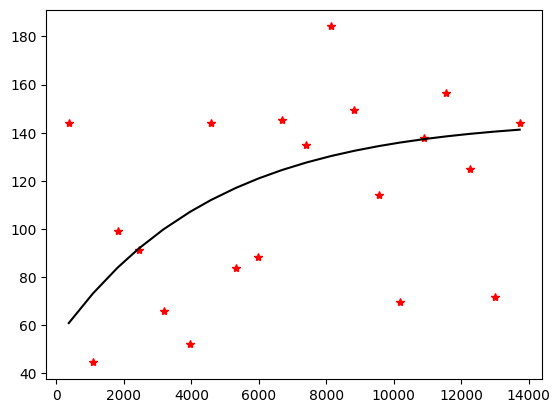

In [ ]:
# Interpolation for each depth field
depth_type = 'Young Bay Mud'
# Ensure depth values are numeric
MS_layers_append[depth_type] = pd.to_numeric(MS_layers_append[depth_type], errors='coerce')

MS_layers_append[['UTM -X', 'UTM -Y']] = MS_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)
# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = MS_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 20, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['MS Method ybm'] = z_interp

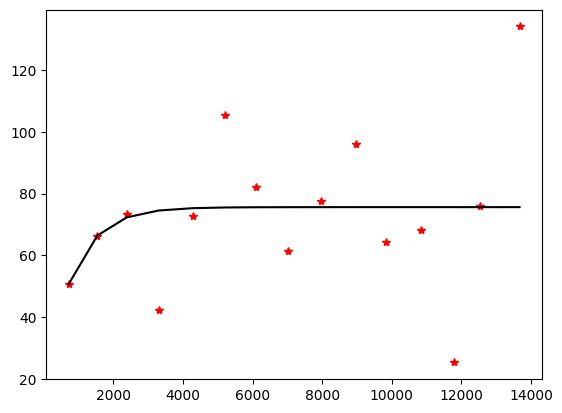

In [ ]:
# Ensure depth values are numeric
MSAF_layers_append[depth_type] = pd.to_numeric(MSAF_layers_append[depth_type], errors='coerce')
MSAF_layers_append[['UTM -X', 'UTM -Y']] = MSAF_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)
# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = MSAF_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 15, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['MSAF Method ybm'] = z_interp

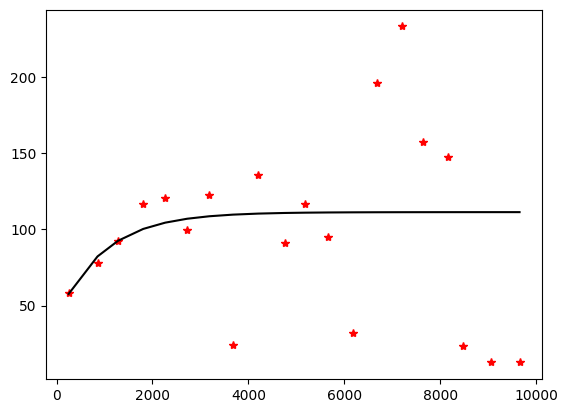

In [ ]:
# Ensure depth values are numeric
geo_layers_append[depth_type] = pd.to_numeric(geo_layers_append[depth_type], errors='coerce')

# fill in utm from geometry in 4326
geo_layers_append[['UTM -X', 'UTM -Y']] = geo_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)

# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = geo_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 20, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['Heuristic ybm'] = z_interp

Text(0.5, 1.0, 'Heuristic')

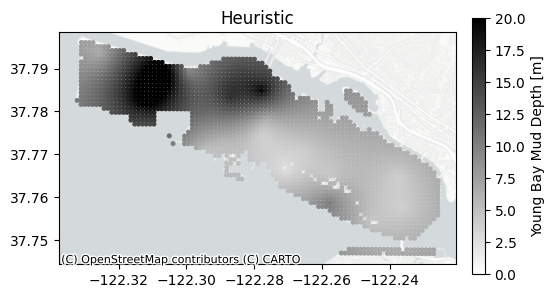

In [ ]:
ax=points.plot(column='Heuristic ybm', legend=True,markersize=7,cmap='gist_gray_r',vmin = 0, vmax=20 )
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Young Bay Mud Depth [m]')
# make the cbar smaller 90% of the original size
cbar.set_position([0.77, 0.22, 0.02, 0.56])
plt.title('Heuristic')

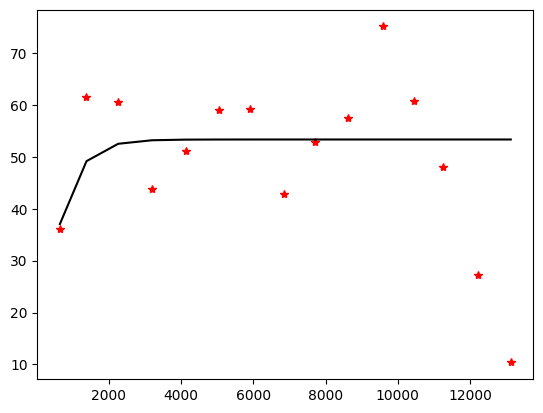

In [ ]:
# Ensure depth values are numeric
hudson_ms_layers_append[depth_type] = pd.to_numeric(hudson_ms_layers_append[depth_type], errors='coerce')

hudson_ms_layers_append[['UTM -X', 'UTM -Y']] = hudson_ms_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)
# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = hudson_ms_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 15, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['MS Hudson ybm'] = z_interp

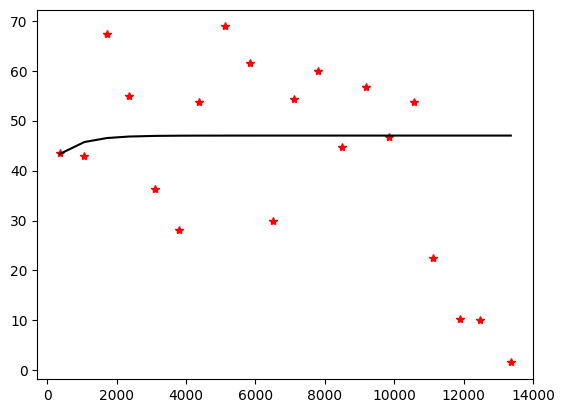

In [ ]:
hudson_msaf_layers_append[depth_type] = pd.to_numeric(hudson_msaf_layers_append[depth_type], errors='coerce')

hudson_msaf_layers_append[['UTM -X', 'UTM -Y']] = hudson_msaf_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)
# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = hudson_msaf_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 20, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['MSAF Hudson ybm'] = z_interp

In [ ]:
points['ybm_heur-MS'] = points['Heuristic ybm'] - points['MS Method ybm']
points['ybm_heur-MSAF'] = points['Heuristic ybm'] - points['MSAF Method ybm']
points['ybm_MS-MSAF'] = points['MS Method ybm'] - points['MSAF Method ybm']
points['ybm_heur-MSHud'] = points['Heuristic ybm'] - points['MS Hudson ybm']
points['ybm_heur-MSAFHud'] = points['Heuristic ybm'] - points['MSAF Hudson ybm']


12.220776663995489


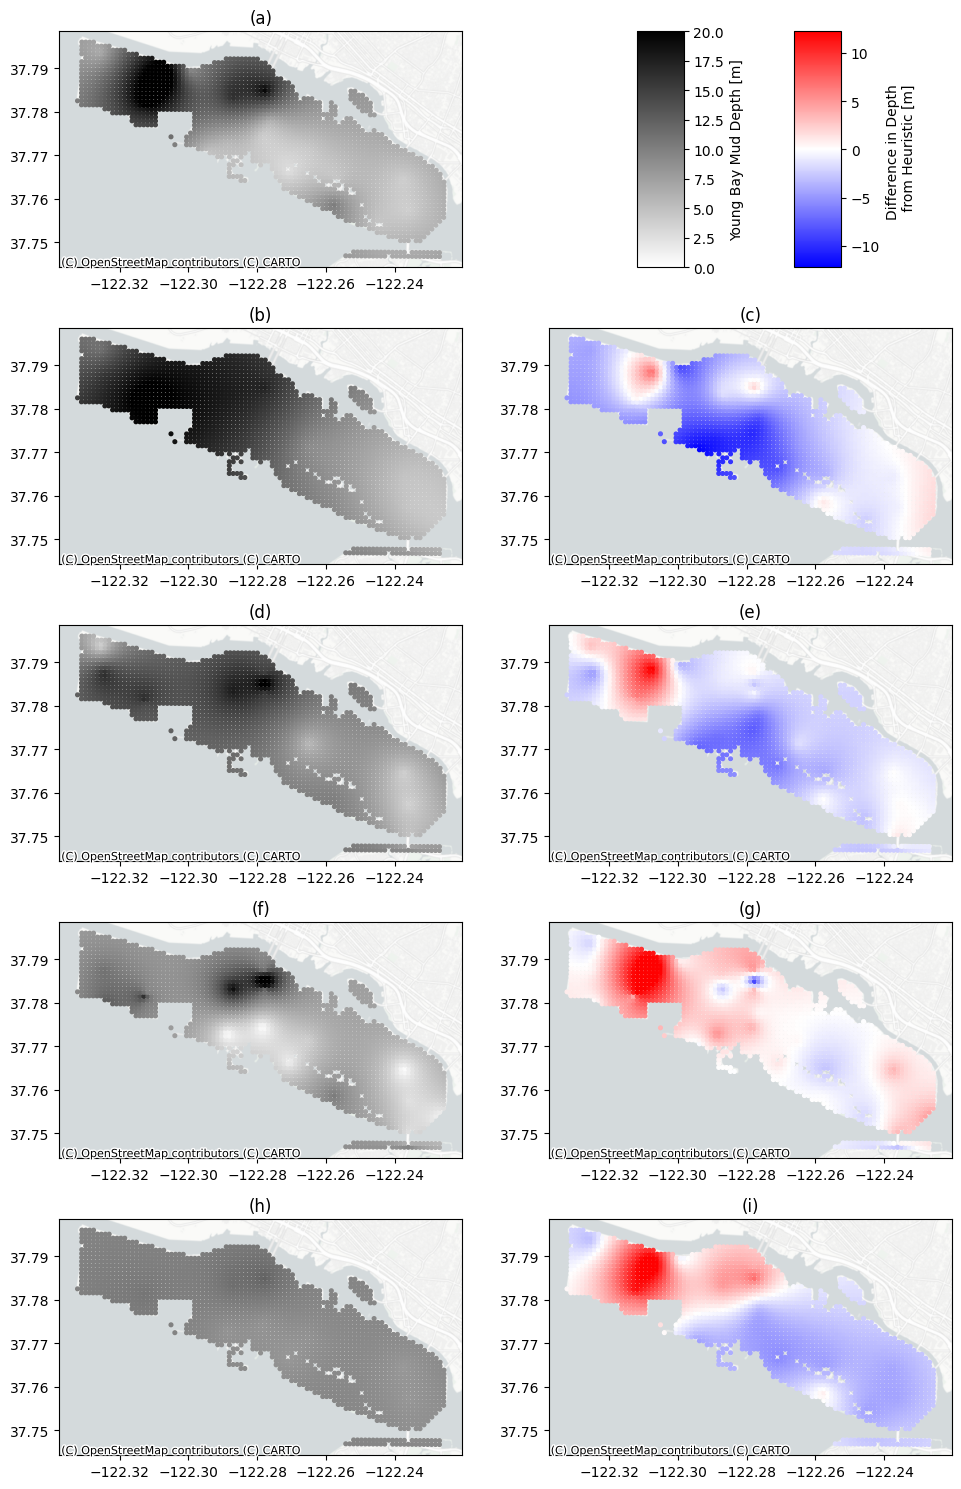

In [ ]:
# I want the above figures laid out like this:
# Heuristic top center
# next row with CPMS left and heur-CPMS right
# then down the rows will be CP MSAF , hud MS, hud MSAF with the differences to the right
# and label them (a) (b) (c) and so on 
# the subplots should have one center top then four rows (5 total) of two columns
lim = max(abs(points['ybm_heur-MS']).max(),abs(points['ybm_heur-MSAF']).max(),abs(points['ybm_MS-MSAF']).max())
print(lim)
# lim = 6
fig, axs = plt.subplots(5, 2, figsize=(10, 15))
ax = points.plot(column='Heuristic ybm', legend=False,markersize=7,vmin = 0, vmax=20, cmap='gist_gray_r', ax=axs[0,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')

ax.set_title('(a)')

ax = points.plot(column='MS Method ybm', legend=False,markersize=7,vmin = 0, vmax=20, cmap='gist_gray_r', ax=axs[1,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(b)')

ax = points.plot(column='ybm_heur-MS', legend=False,markersize=7, cmap='bwr',vmin=-lim,vmax=lim, ax=axs[1,1])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(c)')

ax = points.plot(column='MSAF Method ybm', legend=False,markersize=7,vmin = 0, vmax=20, cmap='gist_gray_r', ax=axs[2,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(d)')

ax = points.plot(column='ybm_heur-MSAF', legend=False,markersize=7, cmap='bwr',vmin=-lim,vmax=lim, ax=axs[2,1])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(e)')

ax = points.plot(column='MS Hudson ybm', legend=False,markersize=7,vmin = 0, vmax=20, cmap='gist_gray_r', ax=axs[3,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(f)')

ax = points.plot(column='ybm_heur-MSHud', legend=False,markersize=7, cmap='bwr',vmin=-lim,vmax=lim, ax=axs[3,1])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(g)')

ax = points.plot(column='MSAF Hudson ybm', legend=False,markersize=7,vmin = 0, vmax=20, cmap='gist_gray_r', ax=axs[4,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(h)')
ax = points.plot(column='ybm_heur-MSAFHud', legend=False,markersize=7, cmap='bwr',vmin=-lim,vmax=lim, ax=axs[4,1])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(i)')

depth_sm = plt.cm.ScalarMappable(cmap='gist_gray_r', norm=plt.Normalize(vmin=0, vmax=20))
depth_sm._A = []

# Delta colorbar
delta_sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=-lim, vmax=lim))
delta_sm._A = []

# Turn off the ghost axis in axs[0, 1]
axs[0, 1].axis('off')

# Adjust the colorbars to be chunkier by changing the 'fraction'
delta_cbar = fig.colorbar(delta_sm, ax=axs[0, 1], orientation='vertical', fraction=0.4, pad=0.2,aspect=5)
delta_cbar.set_label('Difference in Depth \n from Heuristic [m]')

depth_cbar = fig.colorbar(depth_sm, ax=axs[0, 1], orientation='vertical', fraction=0.4, pad=0.02,aspect=5)
depth_cbar.set_label('Young Bay Mud Depth [m]')


plt.tight_layout()

plt.savefig('./figures/ybm_map_compare.png', format='png', dpi=1000,bbox_inches='tight')
plt.savefig('./figures/ybm_map_compare.pdf', format='pdf', dpi=1000,bbox_inches='tight')



#### Now do the same as the above for Merritt Sand 

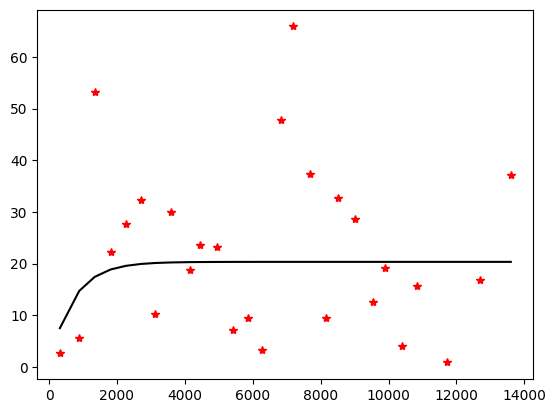

In [ ]:
# Interpolation for each depth field
depth_type = 'Merritt Sand'
# Ensure depth values are numeric
MS_layers_append[depth_type] = pd.to_numeric(MS_layers_append[depth_type], errors='coerce')

MS_layers_append[['UTM -X', 'UTM -Y']] = MS_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)
# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = MS_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 30, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['MS Method ms'] = z_interp

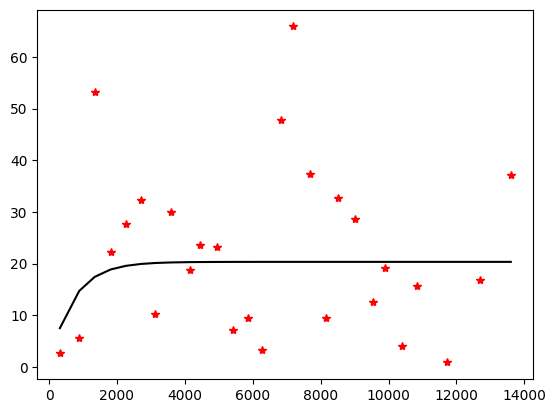

In [ ]:
# Ensure depth values are numeric
MSAF_layers_append[depth_type] = pd.to_numeric(MSAF_layers_append[depth_type], errors='coerce')
MSAF_layers_append[['UTM -X', 'UTM -Y']] = MSAF_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)
# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = MSAF_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 30, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['MSAF Method ms'] = z_interp

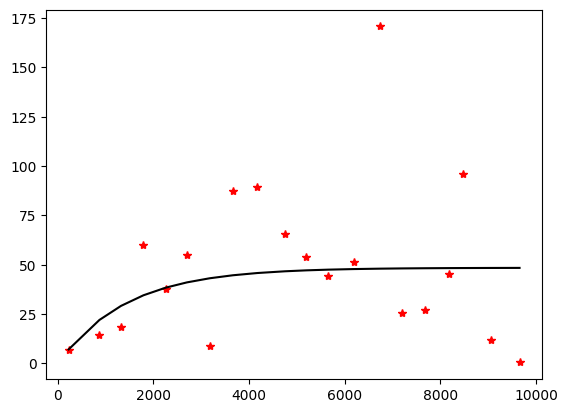

In [ ]:
# Ensure depth values are numeric
geo_layers_append[depth_type] = pd.to_numeric(geo_layers_append['Merrit sand'], errors='coerce')

# fill in utm from geometry in 4326
geo_layers_append[['UTM -X', 'UTM -Y']] = geo_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)

# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = geo_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 20, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['Heuristic ms'] = z_interp

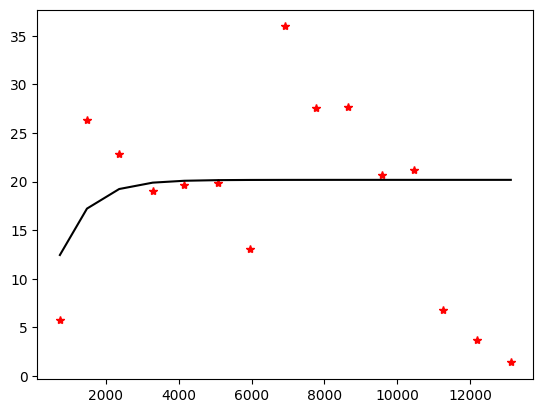

In [ ]:
# Ensure depth values are numeric
hudson_ms_layers_append[depth_type] = pd.to_numeric(hudson_ms_layers_append[depth_type], errors='coerce')

hudson_ms_layers_append[['UTM -X', 'UTM -Y']] = hudson_ms_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)
# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = hudson_ms_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 15, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['MS Hudson ms'] = z_interp

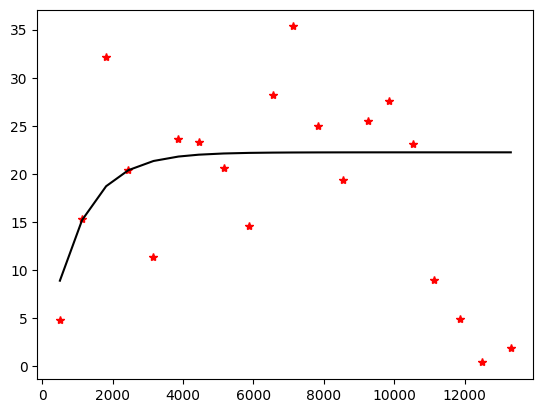

In [ ]:
hudson_msaf_layers_append[depth_type] = pd.to_numeric(hudson_msaf_layers_append[depth_type], errors='coerce')

hudson_msaf_layers_append[['UTM -X', 'UTM -Y']] = hudson_msaf_layers_append.apply(
    lambda row: pd.Series(utm.from_latlon(row.geometry.y, row.geometry.x)[:2]), axis=1)
# Filter out rows with NaN in UTM coordinates or the depth column
valid_layers = hudson_msaf_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])

# Extract valid coordinates and depth values
x_coords = valid_layers['UTM -X'].values.astype(float)
y_coords = valid_layers['UTM -Y'].values.astype(float)
z_values = valid_layers[depth_type].values.astype(float)

if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
    # Perform kriging
    kriging_model = OrdinaryKriging(
        x_coords, y_coords, z_values,
        variogram_model='exponential',
        verbose=False,
        nlags = 20, 
        enable_plotting=True
    )
    
    # Interpolate depths at the points of interest
    z_interp, _ = kriging_model.execute(
        'points', 
        points['utmX'].values.astype(float), 
        points['utmY'].values.astype(float)
    )
    
    points['MSAF Hudson ms'] = z_interp

In [ ]:
points['ms_heur-MS'] = points['Heuristic ms'] - points['MS Method ms']
points['ms_heur-MSAF'] = points['Heuristic ms'] - points['MSAF Method ms']
points['ms_MS-MSAF'] = points['MS Method ms'] - points['MSAF Method ms']
points['ms_heur-MSHud'] = points['Heuristic ms'] - points['MS Hudson ms']
points['ms_heur-MSAFHud'] = points['Heuristic ms'] - points['MSAF Hudson ms']


13.840349842688092


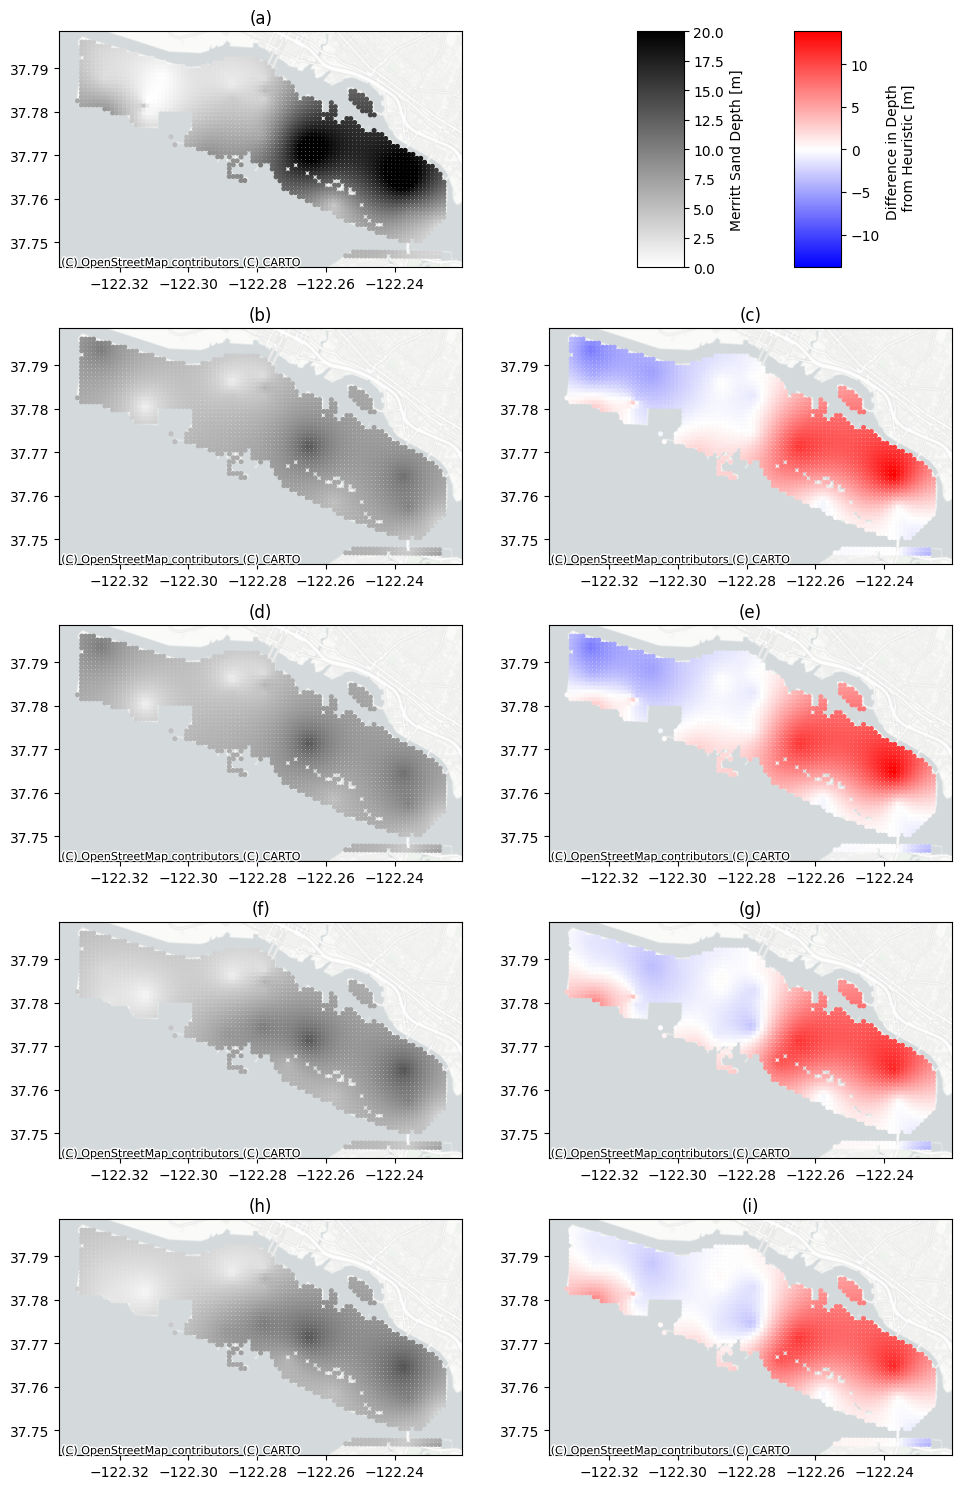

In [ ]:
# I want the above figures laid out like this:
# Heuristic top center
# next row with CPMS left and heur-CPMS right
# then down the rows will be CP MSAF , hud MS, hud MSAF with the differences to the right
# and label them (a) (b) (c) and so on 
# the subplots should have one center top then four rows (5 total) of two columns
lim = max(abs(points['ms_heur-MS']).max(),abs(points['ms_heur-MSAF']).max(),abs(points['ms_MS-MSAF']).max())
print(lim)
# lim = 6
fig, axs = plt.subplots(5, 2, figsize=(10, 15))
ax = points.plot(column='Heuristic ms', legend=False,markersize=7,vmin = 0, vmax=20, cmap='gist_gray_r', ax=axs[0,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')

ax.set_title('(a)')

ax = points.plot(column='MS Method ms', legend=False,markersize=7,vmin = 0, vmax=20, cmap='gist_gray_r', ax=axs[1,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(b)')

ax = points.plot(column='ms_heur-MS', legend=False,markersize=7, cmap='bwr',vmin=-lim,vmax=lim, ax=axs[1,1])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(c)')

ax = points.plot(column='MSAF Method ms', legend=False,markersize=7,vmin = 0, vmax=20, cmap='gist_gray_r', ax=axs[2,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(d)')

ax = points.plot(column='ms_heur-MSAF', legend=False,markersize=7, cmap='bwr',vmin=-lim,vmax=lim, ax=axs[2,1])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(e)')

ax = points.plot(column='MS Hudson ms', legend=False,markersize=7,vmin = 0, vmax=20, cmap='gist_gray_r', ax=axs[3,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(f)')

ax = points.plot(column='ms_heur-MSHud', legend=False,markersize=7, cmap='bwr',vmin=-lim,vmax=lim, ax=axs[3,1])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(g)')

ax = points.plot(column='MSAF Hudson ms', legend=False,markersize=7,vmin = 0, vmax=20, cmap='gist_gray_r', ax=axs[4,0])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(h)')
ax = points.plot(column='ms_heur-MSAFHud', legend=False,markersize=7, cmap='bwr',vmin=-lim,vmax=lim, ax=axs[4,1])
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels,crs='EPSG:4326')
ax.set_title('(i)')

depth_sm = plt.cm.ScalarMappable(cmap='gist_gray_r', norm=plt.Normalize(vmin=0, vmax=20))
depth_sm._A = []

# Delta colorbar
delta_sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=-lim, vmax=lim))
delta_sm._A = []

# Turn off the ghost axis in axs[0, 1]
axs[0, 1].axis('off')

# Adjust the colorbars to be chunkier by changing the 'fraction'
delta_cbar = fig.colorbar(delta_sm, ax=axs[0, 1], orientation='vertical', fraction=0.4, pad=0.2,aspect=5)
delta_cbar.set_label('Difference in Depth \n from Heuristic [m]')

depth_cbar = fig.colorbar(depth_sm, ax=axs[0, 1], orientation='vertical', fraction=0.4, pad=0.02,aspect=5)
depth_cbar.set_label('Merritt Sand Depth [m]')


plt.tight_layout()

plt.savefig('./figures/ms_map_compare.png', format='png', dpi=1000,bbox_inches='tight')
plt.savefig('./figures/ms_map_compare.pdf', format='pdf', dpi=1000,bbox_inches='tight')

